# Experiments on MotionSense Resampled to 20Hz

This notebook will perform basic experiments on the balanced KuHar dataset with the following steps:
1. Quick load train, test and validation CSV subsets from the balanced KuHar dataset using `PandasDatasetsIO` helper
2. Subclassing the `Dataset` interface using `PandasMultiModalDataset`
3. Apply the fourier transform on the dataset
4. Train and evaluate SVM, KNN and Random Forest classification models in the frequency domain, removing high frequencies from gyroscope. Train models by entering range of features (eg 0 to 1Hz, 0 to 2Hz, ..., 0 to 10Hz) and compare performances when adding high frequencies.

The experiments will evaluate the performance of SVM, KNN and RF models on the balanced KuHar dataset in both time and frequency domains.

## Common imports and definitions

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("../../..")

# Third party imports
import pandas as pd
import numpy as np

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-09-20 19:22:14.793375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 19:22:14.793406: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading data
Change the path to use in other datasets

In [2]:
# Path for KuHar resampled to 50Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../../../data/views/MotionSense/resampled_view_20Hz")

Once paths is defined, we can load the CSV as pandas dataframes

In [3]:
# Kuhar dataframes
train, validation, test = PandasDatasetsIO(dataset_path).load()

Lets take a look in the train dataframes

In [4]:
train.head()

,Unnamed: 0,userAcceleration.x-0,userAcceleration.x-1,userAcceleration.x-2,userAcceleration.x-3,userAcceleration.x-4,userAcceleration.x-5,userAcceleration.x-6,userAcceleration.x-7,userAcceleration.x-8,...,rotationRate.z-55,rotationRate.z-56,rotationRate.z-57,rotationRate.z-58,rotationRate.z-59,activity code,length,trial_code,index,user
0,0,-0.101581,-0.221355,-0.234016,-0.264552,-0.200991,-0.208962,-0.308408,0.089943,-0.382516,...,-0.099006,-0.171130,0.292608,0.932535,0.782147,0,150,1,150,11
1,1,-0.082527,0.201136,-0.017408,0.120404,-0.179599,-0.013960,-0.014233,0.253264,0.684288,...,-0.838042,0.241819,0.718420,0.336507,0.936563,0,150,1,900,12
2,2,0.108323,-0.045941,0.017410,0.010881,0.019035,-0.157225,0.016889,-0.076276,0.149599,...,0.497304,0.732298,0.667477,-0.025386,-0.037093,0,150,1,1050,21
3,3,-0.370755,-0.495850,0.205895,0.455012,0.113117,-0.327512,0.111760,0.001935,-0.844532,...,0.919908,0.037076,-0.993926,-0.182277,0.317828,0,150,2,150,17
4,4,-0.005683,0.452370,0.028475,0.402016,0.168378,0.353346,0.182684,0.042545,0.001530,...,-0.060734,0.496173,1.265226,1.502311,0.857408,0,150,11,450,21


## Creating a Librep dataset from pandas dataframes

Change the features to use in other datasets

In [5]:
# MotionSense features to select
features = [
    "userAcceleration.x",
    "userAcceleration.y",
    "userAcceleration.z",
    "rotationRate.x",
    "rotationRate.y",
    "rotationRate.z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    pd.concat([train, validation]),
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# # Validation
# validation_dataset = PandasMultiModalDataset(
#     validation,
#     feature_prefixes=features,
#     label_columns="activity code",
#     as_array=True
# )

# Test
test_dataset = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

## Fourier Transform

In [6]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [7]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

### Use FFT in Kuhar

## Function to remove low/high frequencies

In [8]:
def remove_gyroscope_high_frequencies(X, num_windows, num_per_slices, features, num_features):

    df_fft = []
    df_fft_y = []

    for sample in X:
        s = np.reshape(sample[0],(num_windows,num_per_slices))

        new_sample = []
        acc, gyr = np.array([]), np.array([])

        for i in range(3):
            aux = s[i][:] # Add only acceleremoter frequencies
            acc = np.concatenate((acc, aux), axis=None)

        for j in range(3,num_windows):
            aux = s[j][:num_features] # Remove only gyroscope frequencies
            gyr = np.concatenate((gyr, aux), axis=None)

        new_sample = np.concatenate((acc, gyr), axis=None)

        df_fft.append(new_sample)
        df_fft_y.append(sample[1])
    df_fft = np.array(df_fft)
    df_fft_y = np.array(df_fft_y)

    df_fft = pd.DataFrame(df_fft,columns=features)
    df_fft['activity code'] = df_fft_y

    features =[
        'fft.userAcceleration.x',
         'fft.userAcceleration.y',
         'fft.userAcceleration.z',
         'fft.rotationRate.x',
         'fft.rotationRate.y',
         'fft.rotationRate.z'
    ]

    df_fft = PandasMultiModalDataset(
        df_fft,
        feature_prefixes=features,
        label_columns="activity code",
        as_array=True
    )

    return df_fft

fs_cut = 10
train_fft = transformer(train_dataset)
test_fft = transformer(test_dataset)

num_windows = train_fft.num_windows # It's equal the number of sensors
num_per_slices = train_fft.window_slices[0][1] # It's equal the number of features for sensor
num_per_frequency = num_per_slices // fs_cut

## Train and evaluate Random Forest classifier

In [9]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier
from librep.metrics.report import ClassificationReport
import yaml

reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [10]:
k = 1
results_rf = []

# Add names to accelerometer frequencies
acc_name = []
for i in range(3):
    for j in range(fs_cut*3):
        acc_name.append(train_fft.window_names[i]+'-{}'.format(j)) # Rename the features name

while(k <= fs_cut):
    num_features = num_per_frequency*k

    features = acc_name.copy()

    # Add names to gyroscope frequencies
    for i in range(3, num_windows):
        for j in range(num_features):
            features.append(train_fft.window_names[i]+'-{}'.format(j)) # Rename the features name

    train_fft_reduced = remove_gyroscope_high_frequencies(train_fft, num_windows, num_per_slices, features, 
                                               num_features)
    test_fft_reduced = remove_gyroscope_high_frequencies(test_fft, num_windows, num_per_slices, features, 
                                              num_features)

    result = multi_run_experiment(train_fft_reduced, test_fft_reduced)
    results_rf.append(result)
    print('Iteração: ', k)
    k+=1

Iteração:  1
Iteração:  2
Iteração:  3
Iteração:  4
Iteração:  5
Iteração:  6
Iteração:  7
Iteração:  8
Iteração:  9
Iteração:  10


## Train and evaluate Support Vector Machine classifier

In [11]:
from librep.estimators import SVC

experiment = SimpleTrainEvalWorkflow(estimator=SVC, estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

k = 1
results_svc = []

# Add names to accelerometer frequencies
acc_name = []
for i in range(3):
    for j in range(fs_cut*3):
        acc_name.append(train_fft.window_names[i]+'-{}'.format(j)) # Rename the features name

while(k <= fs_cut):
    num_features = num_per_frequency*k

    features = acc_name.copy()

    # Add names to gyroscope frequencies
    for i in range(3, num_windows):
        for j in range(num_features):
            features.append(train_fft.window_names[i]+'-{}'.format(j)) # Rename the features name

    train_fft_reduced = remove_gyroscope_high_frequencies(train_fft, num_windows, num_per_slices, features, 
                                               num_features)
    test_fft_reduced = remove_gyroscope_high_frequencies(test_fft, num_windows, num_per_slices, features, 
                                              num_features)

    result = multi_run_experiment(train_fft_reduced, test_fft_reduced)
    results_svc.append(result)
    print('Iteração: ', k)
    k+=1

Iteração:  1
Iteração:  2
Iteração:  3
Iteração:  4
Iteração:  5
Iteração:  6
Iteração:  7
Iteração:  8
Iteração:  9
Iteração:  10


## Train and evaluate K Neighbors Classifier classifier

In [12]:
from librep.estimators import KNeighborsClassifier

experiment = SimpleTrainEvalWorkflow(estimator=KNeighborsClassifier, estimator_creation_kwags ={'n_neighbors' :1} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

k = 1
results_knn = []

# Add names to accelerometer frequencies
acc_name = []
for i in range(3):
    for j in range(fs_cut*3):
        acc_name.append(train_fft.window_names[i]+'-{}'.format(j)) # Rename the features name

while(k <= fs_cut):
    num_features = num_per_frequency*k

    features = acc_name.copy()

    # Add names to gyroscope frequencies
    for i in range(3, num_windows):
        for j in range(num_features):
            features.append(train_fft.window_names[i]+'-{}'.format(j)) # Rename the features name

    train_fft_reduced = remove_gyroscope_high_frequencies(train_fft, num_windows, num_per_slices, features, 
                                               num_features)
    test_fft_reduced = remove_gyroscope_high_frequencies(test_fft, num_windows, num_per_slices, features, 
                                              num_features)

    result = multi_run_experiment(train_fft_reduced, test_fft_reduced)
    results_knn.append(result)
    print('Iteração: ', k)
    k+=1

Iteração:  1
Iteração:  2
Iteração:  3
Iteração:  4
Iteração:  5
Iteração:  6
Iteração:  7
Iteração:  8
Iteração:  9
Iteração:  10


In [13]:
def chart(classifiers, metric, xlabel, title, fs_cut):
    X = ['[{}, {}]'.format(0, i) for i in range(1, fs_cut+1)]
    for classifier in classifiers:
        plt.plot(X, classifiers[classifier][metric], label=classifier) 

    plt.xlabel(xlabel) 
    plt.ylabel(metric) 
    plt.title(title) 
    plt.xlim(0,fs_cut-1)
    plt.legend() 
    plt.grid()
    plt.show()

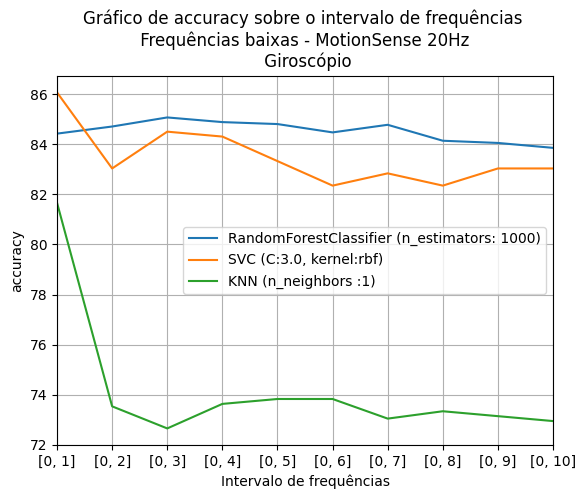

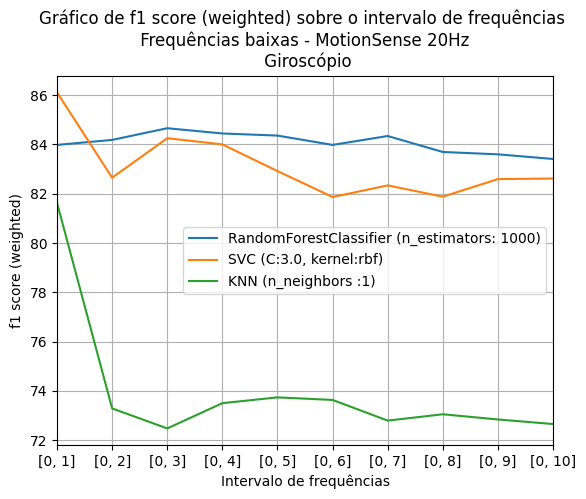

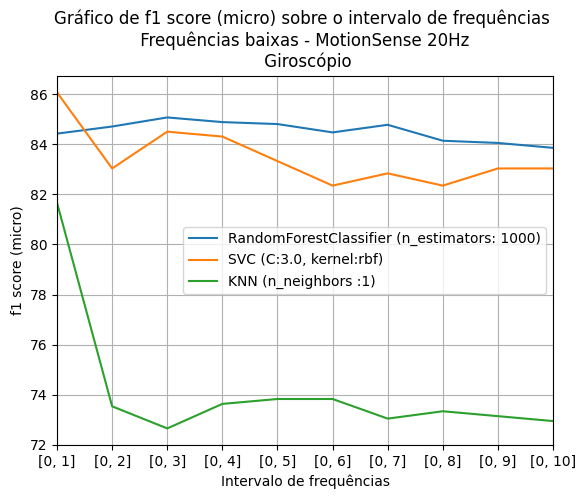

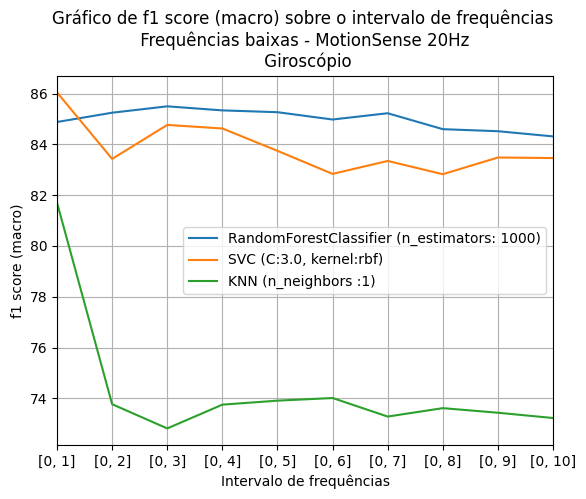

In [14]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'f1 score (weighted)', 'f1 score (micro)', 'f1 score (macro)']

scores_rf = {metric:[] for metric in metrics}
scores_rf_average = {metric:[] for metric in metrics}

scores_svc = {metric:[] for metric in metrics}
scores_svc_average = {metric:[] for metric in metrics}

scores_knn = {metric:[] for metric in metrics}
scores_knn_average = {metric:[] for metric in metrics}

for metric in metrics:
    for i in range(fs_cut):
            score_rf, score_svc, score_knn = [], [], []
            for j in range(10):
                value_rf = results_rf[i]['runs'][j]['result'][0][metric]
                score_rf.append(100*value_rf)

                value_svc = results_svc[i]['runs'][j]['result'][0][metric]
                score_svc.append(100*value_svc)

                value_knn = results_knn[i]['runs'][j]['result'][0][metric]
                score_knn.append(100*value_knn)

            scores_rf[metric].append(score_rf)
            scores_rf_average[metric].append(np.mean(score_rf))

            scores_svc[metric].append(score_svc)
            scores_svc_average[metric].append(np.mean(score_svc))

            scores_knn[metric].append(score_knn)
            scores_knn_average[metric].append(np.mean(score_knn))

classifiers = {
    'RandomForestClassifier (n_estimators: 1000)' : scores_rf_average,
    'SVC (C:3.0, kernel:rbf)' : scores_svc_average,
    'KNN (n_neighbors :1)' : scores_knn_average
}
for metric in metrics:
    xlabel = "Intervalo de frequências"
    # ylabel = metric
    title = "Gráfico de {} sobre o intervalo de frequências \n Frequências baixas - MotionSense {}Hz \n Giroscópio".format(metric, 
                                                                                                    fs_cut*2)
    chart(classifiers, metric, xlabel, title, fs_cut)

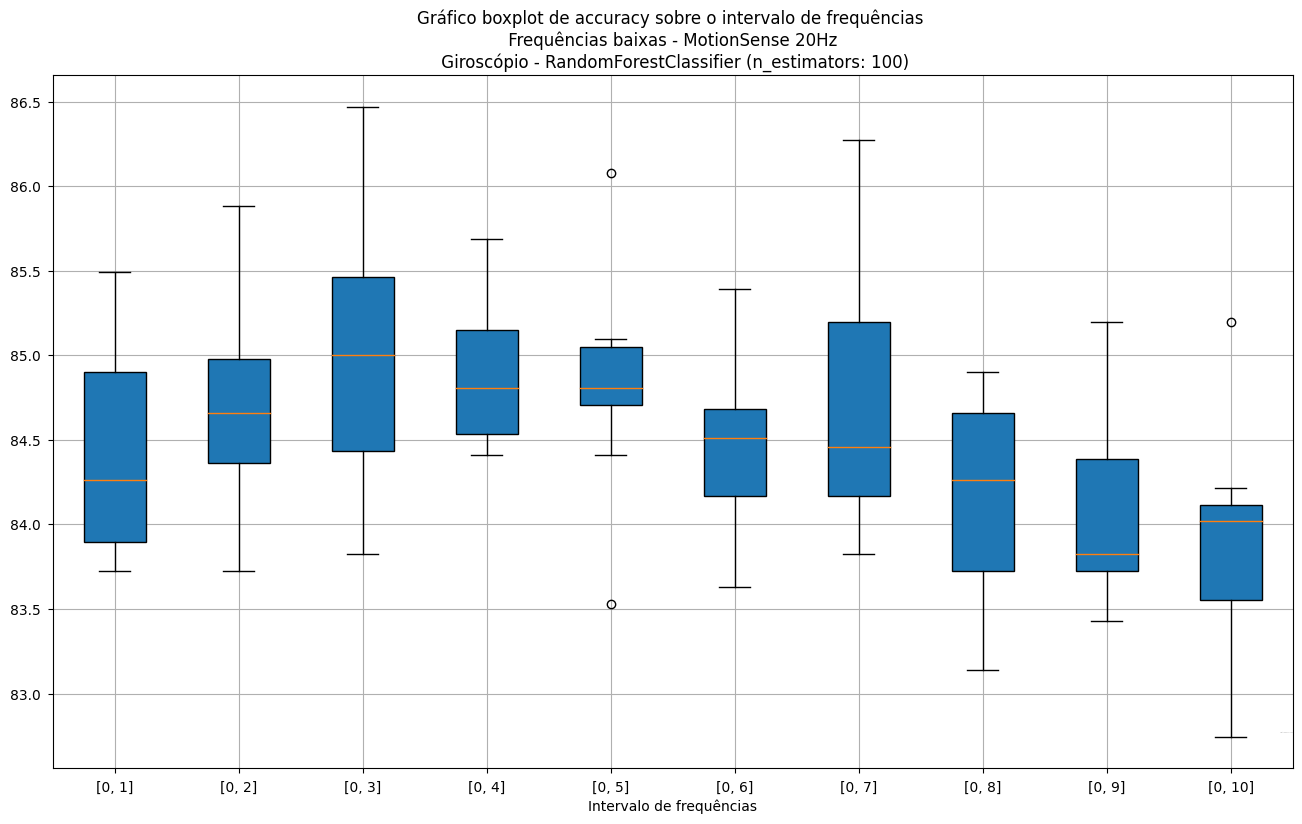

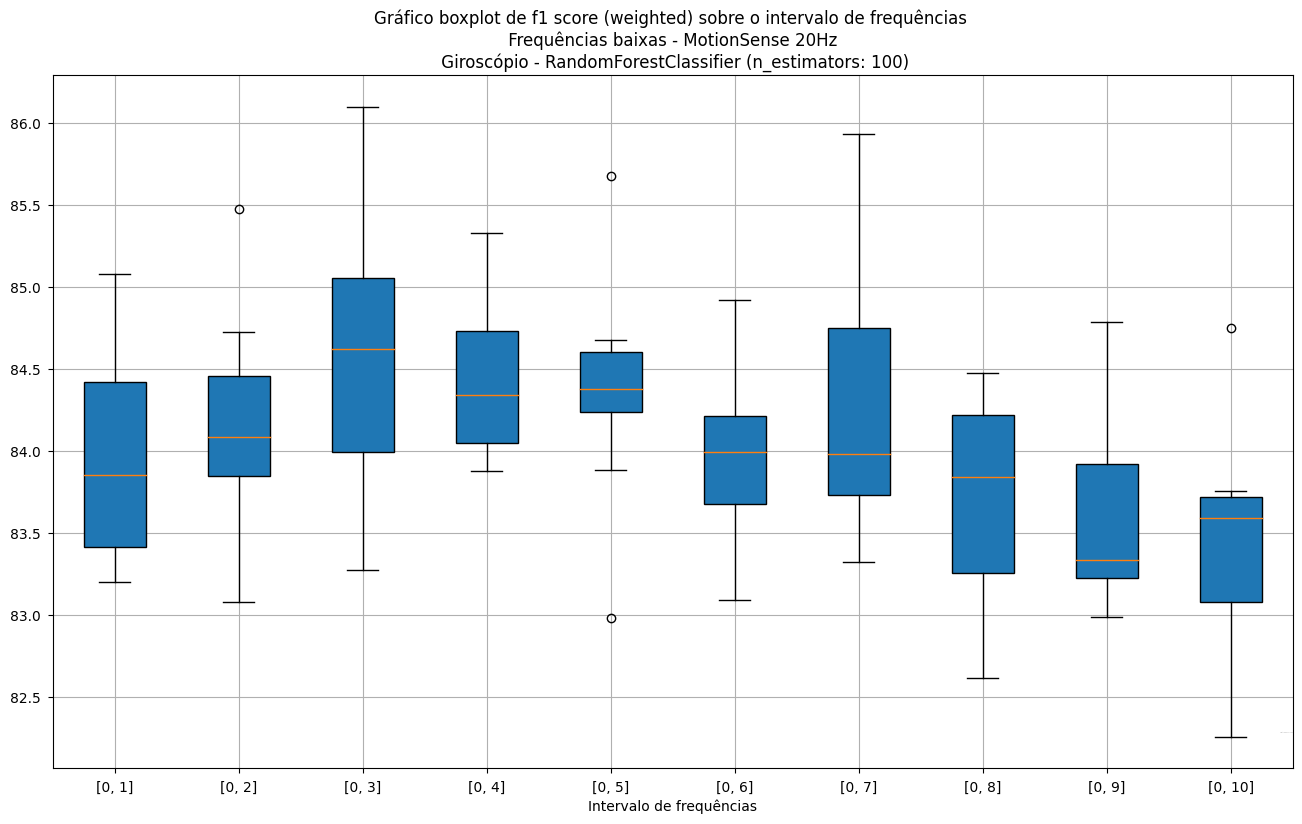

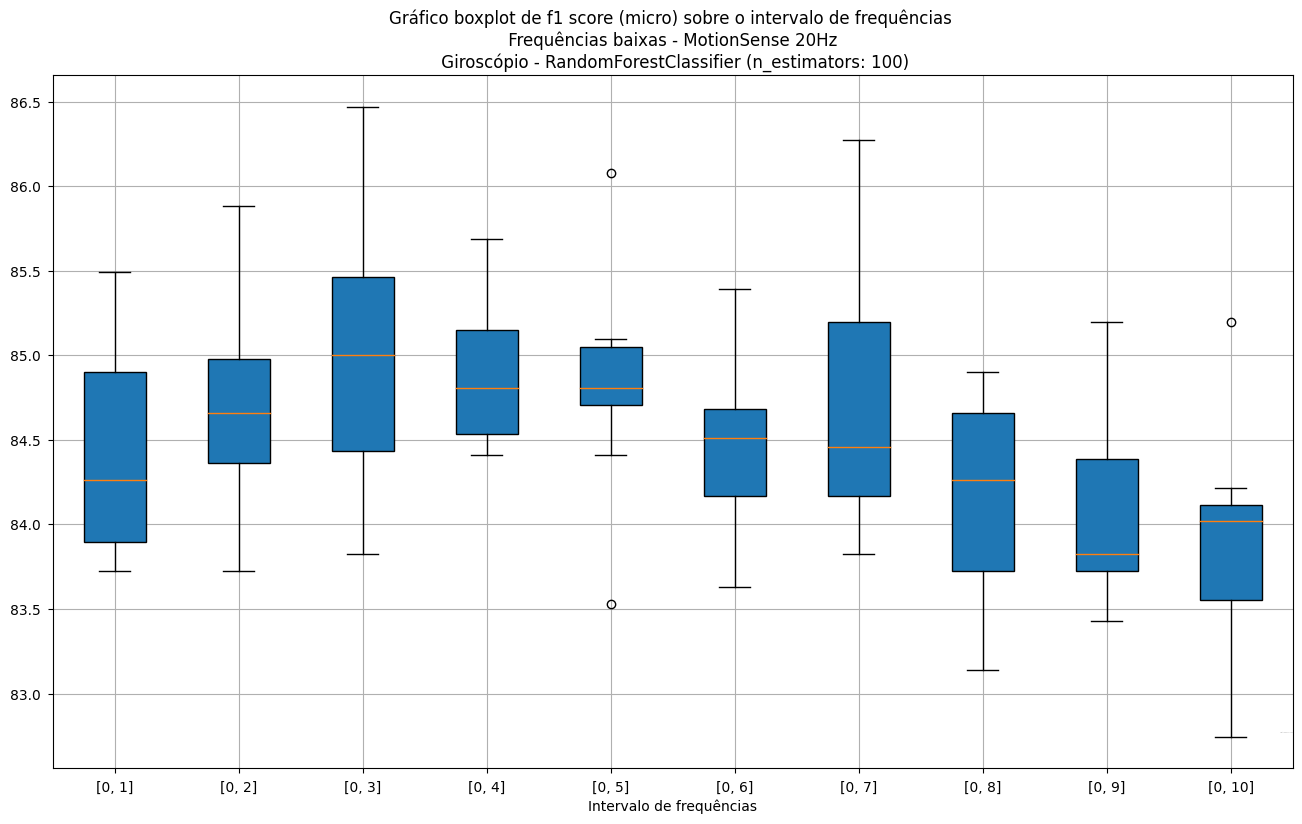

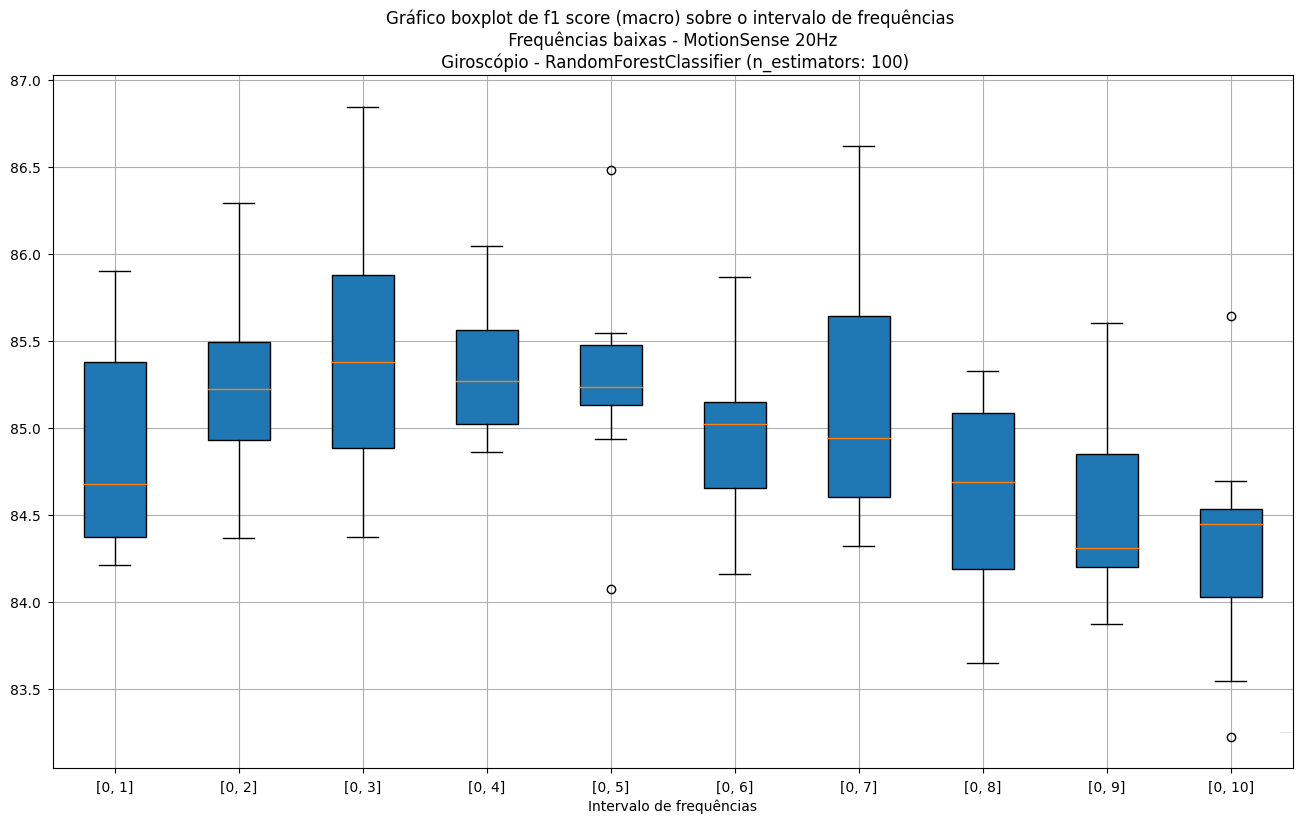

In [16]:
def plotBoxplot(X, Y, xlabel, title, fs_cut):
    # Figure Size
    fig, ax = plt.subplots(figsize =(16, 9))

    # Horizontal Box Plor

    bplot1 = ax.boxplot(Y, vert = 1, patch_artist = True)
    ax.set_xticklabels(X)

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 5)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    # Show top values
#     ax.invert_yaxis()
    ax.grid()

    # Add Text watermark
    fig.text(0.9, 0.15, 'Jeeteshgavande30', fontsize = 0, color ='grey', ha ='right', va ='bottom', 
             alpha = 0.7)

    # Show Plot
    plt.show()

metrics = ['accuracy', 'f1 score (weighted)', 'f1 score (micro)', 'f1 score (macro)']

scores_rf = {metric:[] for metric in metrics}
scores_svc = {metric:[] for metric in metrics}
scores_knn = {metric:[] for metric in metrics}

for metric in metrics:
    for i in range(fs_cut):
            score_rf, score_svc, score_knn = [], [], []
            for j in range(10):
                value_rf = results_rf[i]['runs'][j]['result'][0][metric]
                score_rf.append(100*value_rf)

            scores_rf[metric].append(score_rf)
            # scores_rf_average[metric].append(np.mean(score_rf))

X = ['[{}, {}]'.format(0, i) for i in range(1, fs_cut+1)]
for metric in metrics:
    xlabel = "Intervalo de frequências"
    # ylabel = metric

    title = "Gráfico boxplot de {} sobre o intervalo de frequências \n Frequências baixas - MotionSense {}Hz \n Giroscópio - {}".format(metric, 
                                                                                                                                 fs_cut*2, 'RandomForestClassifier (n_estimators: 100)')
    plotBoxplot(X, scores_rf[metric], xlabel, title, fs_cut)

In [17]:
import pickle

def inserirArquivo(result, geekyfile):

    try: 
        geeky_file = open(geekyfile, 'wb') 
        pickle.dump(result, geeky_file) 
        geeky_file.close() 

    except: 
        print("Something went wrong")

arq_name = 'MotionSense_20Hz_removing_gyroscope_high_frequencies'
inserirArquivo(classifiers, arq_name)